In [1]:
import os
import sys
sys.path.insert(0, "../LIB")
sys.path.insert(0, "../W_screw/")
import dislocation as sd
from ase_lammpslib import LAMMPSlib
import numpy as np
from ase.lattice.cubic import BodyCenteredCubic
from ase.eos import EquationOfState
from ase.units import kJ

W_pot_file = '../W_screw/potentials/w_eam3.fs'

lammps_eam3 = LAMMPSlib(lmpcmds=["pair_style eam/fs",
                           "pair_coeff * * %s W" % W_pot_file],
                           atom_types={'W': 1}, keep_alive=True)

W_pot_file = '../W_screw/potentials/w_fs_eam.fs'

lammps_fs = LAMMPSlib(lmpcmds=["pair_style eam/fs",
                            "pair_coeff * * %s W" % W_pot_file],
                           atom_types={'W': 1}, keep_alive=True)

/root/myatomman/atomman/tools/istypes.py:20: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(dtype.type, int):


In [2]:
from ase.io.trajectory import Trajectory

def energy_volume(calculator, save_traj=False, 
                  guess_alat=3.14, delta=1e-2):

    alat_values = np.linspace(guess_alat - guess_alat * delta, 
                              guess_alat + guess_alat * delta, 21)

    E = []
    
    if save_traj:
        traj = Trajectory('W.traj', 'w')    
    
    for alat in alat_values:
        W = BodyCenteredCubic(symbol='W',
                              pbc=(True, True, True),
                              latticeconstant=alat, debug=0)
        
        W.set_calculator(calculator)
        E_tmp = W.get_potential_energy()
        
        E.append(E_tmp)
        #print(alat, E_tmp)
        
        if save_traj:
            traj.write(W)
        
    return alat_values, np.array(E)

import matplotlib.pyplot as plt
import pandas as pd

def plot_eos(volumes, energies, 
             ax=None,
             marker="o",
             linestyle="solid", 
             pot_name="foo"):
    
    if ax is None:
        figure, ax = plt.subplots()
    
    eos = EquationOfState(volumes, energies)
    v0, e0, B = eos.fit()
    B = B / kJ * 1.0e24
    a0 = v0 ** (1. / 3.)
    E_fit = eos.fit0(volumes**(-1./3))
    
    ax.scatter(volumes**(1./3), energies - e0, marker=marker,
               label=pot_name + " B = %.1f GPa; $a_0$ = %.3f $\AA$" % (B, a0))
    
    line, = ax.plot(volumes**(1./3), E_fit - e0, linestyle=linestyle)
    
    ax.axvline(a0, ymax=0.025, color=line.get_color())
        
    ax.legend(loc="best")
    ax.grid(True, linestyle="dashed")

    ax.set_ylabel("Energy, eV")
    ax.set_xlabel("Lattice constant, $\AA$")

    return ax, B, a0



In [3]:
from ase.calculators.calculator import Calculator
import numpy as np

class RescaledCalculator(Calculator):
    '''
        Rescales the MM calculators to match QM lattice unit and bulk modulus
    '''
    implemented_properties = ['forces', "energy", "stress"]

    def __init__(self, mm_calc, alpha=1., beta=1.):
        Calculator.__init__(self)
        self.mm_calc = mm_calc
        self.alpha = alpha
        self.beta = beta

    def calculate(self, atoms, properties, system_changes):
        Calculator.calculate(self, atoms, properties, system_changes)
        
        #mm_pos = atoms.get_positions()
        scaled_atoms = atoms.copy()
        
        #scaled_atoms.positions = mm_pos/self.alpha
        mm_cell = atoms.get_cell()
        scaled_atoms.set_cell(mm_cell/self.alpha, scale_atoms=True)
        
        forces = self.mm_calc.get_forces(scaled_atoms)
        energy = self.mm_calc.get_potential_energy(scaled_atoms)
        stress = self.mm_calc.get_stress(scaled_atoms)

       
        self.results = {'energy' : energy / self.beta,
                        'forces' : forces / (self.beta * self.alpha),
                        'stress' : stress / (self.beta * self.alpha**3)}
        

In [4]:
fs_alat, fs_C11, fs_C12, fs_C44 = sd.get_elastic_constants(calculator=lammps_fs) 
eam3_alat, eam3_C11, eam3_C12, eam3_C44 = sd.get_elastic_constants(calculator=lammps_eam3) 

      Step     Time          Energy         fmax
FIRE:    0 17:10:59       -8.899953        0.2560
FIRE:    1 17:11:00       -8.900307        0.0207
FIRE:    2 17:11:00       -8.900013        0.2341
FIRE:    3 17:11:00       -8.900134        0.1802
FIRE:    4 17:11:00       -8.900270        0.0848
FIRE:    5 17:11:00       -8.900305        0.0301
FIRE:    6 17:11:00       -8.900305        0.0283
FIRE:    7 17:11:00       -8.900306        0.0250
FIRE:    8 17:11:00       -8.900307        0.0202
FIRE:    9 17:11:00       -8.900308        0.0142
FIRE:   10 17:11:00       -8.900309        0.0075
FIRE:   11 17:11:00       -8.900309        0.0003
FIRE:   12 17:11:00       -8.900309        0.0070
FIRE:   13 17:11:00       -8.900309        0.0069
FIRE:   14 17:11:00       -8.900309        0.0067
FIRE:   15 17:11:00       -8.900309        0.0064
FIRE:   16 17:11:00       -8.900309        0.0060
FIRE:   17 17:11:00       -8.900309        0.0055
FIRE:   18 17:11:00       -8.900309        0.0050
F

In [6]:
print(fs_alat, fs_C11, fs_C12, fs_C44)
print(eam3_alat, eam3_C11, eam3_C12, eam3_C44)

fs_bulk_mod = (fs_C11 + 2.0*fs_C12)/3.0
alpha = eam3_alat/fs_alat
eam3_bulk_mod = (eam3_C11 + 2.0*eam3_C12)/3.0
fs_bulk_mod = (fs_C11 + 2.0*fs_C12)/3.0
beta = fs_bulk_mod/eam3_bulk_mod/(alpha**3)
print(eam3_bulk_mod, fs_bulk_mod)
print ("Alpha: %.2f, beta: %.2f" % (alpha, beta))
Rescaled_lammps = RescaledCalculator(lammps_fs, alpha=alpha, beta=beta)

(3.1650808157749317, 531.9530337758813, 205.59878963062656, 161.88726049622588)
(3.1873779570815275, 438.0213409691751, 183.03614929707052, 140.07172772658166)
(268.03121318777204, 314.3835376790448)
Alpha: 1.01, beta: 1.15


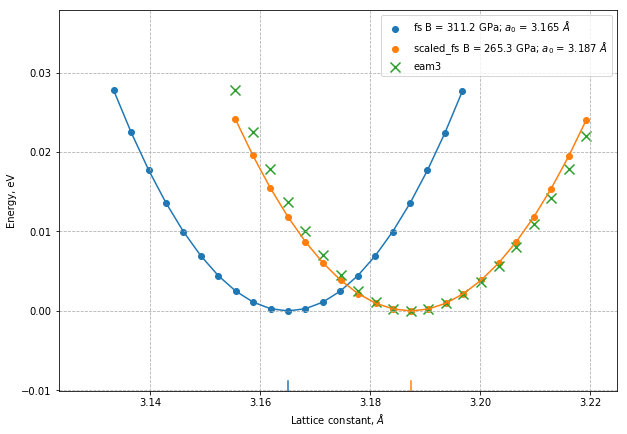

In [7]:
import matplotlib.pyplot as plt
from ase.io import read

fig, ax = plt.subplots(figsize=(10, 7))

alat, E = energy_volume(calculator=lammps_fs, guess_alat=fs_alat)
plot_eos(alat**3, E, ax=ax, pot_name="fs")
alat2, E2 = energy_volume(calculator=Rescaled_lammps, guess_alat=eam3_alat)
plot_eos(alat2**3, E2, ax=ax, pot_name="scaled_fs")

alat, E = energy_volume(calculator=lammps_eam3, guess_alat=eam3_alat)
ax.scatter(alat, E - E.min(), marker='x', s=100, label="eam3")
ax.legend(loc="best")

In [11]:
dislo, bulk, u = sd.make_screw_cyl(eam3_alat, eam3_C11, eam3_C12, eam3_C44, cylinder_r=30)

In [17]:
from ase.optimize import FIRE
cylinder_r = 30
disloc_fin, disloc_eam3, bulk = sd.make_barrier_configurations(calculator=lammps_eam3, cylinder_r=cylinder_r)
disloc_eam3.set_calculator(lammps_eam3)
opt = FIRE(disloc_eam3)
opt.run(fmax=1.0e-3)


      Step     Time          Energy         fmax
FIRE:    0 17:13:23       -8.888960        1.3604
FIRE:    1 17:13:23       -8.899137        0.1274
FIRE:    2 17:13:24       -8.892617        0.9791
FIRE:    3 17:13:24       -8.894767        0.8054
FIRE:    4 17:13:24       -8.897611        0.4864
FIRE:    5 17:13:24       -8.899191        0.0735
FIRE:    6 17:13:24       -8.898097        0.4582
FIRE:    7 17:13:24       -8.898224        0.4319
FIRE:    8 17:13:24       -8.898449        0.3806
FIRE:    9 17:13:24       -8.898720        0.3072
FIRE:   10 17:13:24       -8.898976        0.2156
FIRE:   11 17:13:24       -8.899158        0.1111
FIRE:   12 17:13:24       -8.899224        0.0032
FIRE:   13 17:13:24       -8.899169        0.0942
FIRE:   14 17:13:24       -8.899171        0.0931
FIRE:   15 17:13:24       -8.899173        0.0908
FIRE:   16 17:13:24       -8.899177        0.0874
FIRE:   17 17:13:24       -8.899182        0.0830
FIRE:   18 17:13:24       -8.899188        0.0775
F

FIRE:   69 17:13:27    -7797.839783        0.0038
FIRE:   70 17:13:27    -7797.839784        0.0021
FIRE:   71 17:13:27    -7797.839786        0.0021
FIRE:   72 17:13:27    -7797.839788        0.0021
FIRE:   73 17:13:27    -7797.839790        0.0033
FIRE:   74 17:13:27    -7797.839793        0.0041
FIRE:   75 17:13:27    -7797.839797        0.0040
FIRE:   76 17:13:27    -7797.839801        0.0035
FIRE:   77 17:13:27    -7797.839806        0.0025
FIRE:   78 17:13:27    -7797.839813        0.0018
FIRE:   79 17:13:27    -7797.839820        0.0025
FIRE:   80 17:13:27    -7797.839829        0.0033
FIRE:   81 17:13:27    -7797.839839        0.0026
FIRE:   82 17:13:27    -7797.839850        0.0015
FIRE:   83 17:13:27    -7797.839863        0.0033
FIRE:   84 17:13:27    -7797.839877        0.0022
FIRE:   85 17:13:27    -7797.839893        0.0020
FIRE:   86 17:13:27    -7797.839910        0.0029
FIRE:   87 17:13:27    -7797.839928        0.0018
FIRE:   88 17:13:27    -7797.839948        0.0017


FIRE:  233 17:13:32    -7797.840429        0.0049
FIRE:  234 17:13:32    -7797.840436        0.0049
FIRE:  235 17:13:32    -7797.840445        0.0052
FIRE:  236 17:13:32    -7797.840455        0.0073
FIRE:  237 17:13:32    -7797.840463        0.0239
FIRE:  238 17:13:32    -7797.840430        0.0795
FIRE:  239 17:13:32    -7797.840479        0.0205
FIRE:  240 17:13:32    -7797.840481        0.0141
FIRE:  241 17:13:32    -7797.840483        0.0053
FIRE:  242 17:13:32    -7797.840483        0.0082
FIRE:  243 17:13:32    -7797.840483        0.0076
FIRE:  244 17:13:32    -7797.840483        0.0068
FIRE:  245 17:13:32    -7797.840484        0.0060
FIRE:  246 17:13:32    -7797.840484        0.0052
FIRE:  247 17:13:32    -7797.840484        0.0048
FIRE:  248 17:13:32    -7797.840484        0.0050
FIRE:  249 17:13:32    -7797.840484        0.0054
FIRE:  250 17:13:32    -7797.840484        0.0058
FIRE:  251 17:13:32    -7797.840485        0.0059
FIRE:  252 17:13:32    -7797.840485        0.0056


FIRE:  397 17:13:36    -7797.840847        0.0031
FIRE:  398 17:13:36    -7797.840847        0.0030
FIRE:  399 17:13:36    -7797.840847        0.0029
FIRE:  400 17:13:37    -7797.840847        0.0028
FIRE:  401 17:13:37    -7797.840847        0.0027
FIRE:  402 17:13:37    -7797.840847        0.0026
FIRE:  403 17:13:37    -7797.840847        0.0025
FIRE:  404 17:13:37    -7797.840847        0.0025
FIRE:  405 17:13:37    -7797.840847        0.0025
FIRE:  406 17:13:37    -7797.840847        0.0026
FIRE:  407 17:13:37    -7797.840847        0.0027
FIRE:  408 17:13:37    -7797.840847        0.0027
FIRE:  409 17:13:37    -7797.840847        0.0027
FIRE:  410 17:13:37    -7797.840847        0.0026
FIRE:  411 17:13:37    -7797.840848        0.0025
FIRE:  412 17:13:37    -7797.840848        0.0025
FIRE:  413 17:13:37    -7797.840848        0.0026
FIRE:  414 17:13:37    -7797.840848        0.0026
FIRE:  415 17:13:37    -7797.840849        0.0025
FIRE:  416 17:13:37    -7797.840849        0.0025


FIRE:  561 17:13:41    -7797.840925        0.0013
FIRE:  562 17:13:41    -7797.840925        0.0013
FIRE:  563 17:13:41    -7797.840925        0.0013
FIRE:  564 17:13:41    -7797.840925        0.0013
FIRE:  565 17:13:41    -7797.840925        0.0013
FIRE:  566 17:13:41    -7797.840926        0.0013
FIRE:  567 17:13:42    -7797.840926        0.0013
FIRE:  568 17:13:42    -7797.840926        0.0013
FIRE:  569 17:13:42    -7797.840927        0.0014
FIRE:  570 17:13:42    -7797.840927        0.0014
FIRE:  571 17:13:42    -7797.840928        0.0014
FIRE:  572 17:13:42    -7797.840928        0.0015
FIRE:  573 17:13:42    -7797.840929        0.0051
FIRE:  574 17:13:42    -7797.840928        0.0170
FIRE:  575 17:13:42    -7797.840930        0.0035
FIRE:  576 17:13:42    -7797.840930        0.0025
FIRE:  577 17:13:42    -7797.840930        0.0014
FIRE:  578 17:13:42    -7797.840930        0.0014
FIRE:  579 17:13:42    -7797.840930        0.0014
FIRE:  580 17:13:42    -7797.840930        0.0014


FIRE:  725 17:13:46    -7797.840961        0.0022
FIRE:  726 17:13:46    -7797.840962        0.0035
FIRE:  727 17:13:46    -7797.840962        0.0097
FIRE:  728 17:13:46    -7797.840963        0.0021
FIRE:  729 17:13:46    -7797.840963        0.0021
FIRE:  730 17:13:46    -7797.840963        0.0021
FIRE:  731 17:13:46    -7797.840963        0.0021
FIRE:  732 17:13:46    -7797.840963        0.0021
FIRE:  733 17:13:46    -7797.840963        0.0021
FIRE:  734 17:13:46    -7797.840963        0.0021
FIRE:  735 17:13:46    -7797.840963        0.0021
FIRE:  736 17:13:46    -7797.840963        0.0021
FIRE:  737 17:13:46    -7797.840963        0.0021
FIRE:  738 17:13:46    -7797.840964        0.0021
FIRE:  739 17:13:46    -7797.840964        0.0021
FIRE:  740 17:13:47    -7797.840964        0.0021
FIRE:  741 17:13:47    -7797.840964        0.0021
FIRE:  742 17:13:47    -7797.840965        0.0022
FIRE:  743 17:13:47    -7797.840965        0.0022
FIRE:  744 17:13:47    -7797.840965        0.0022


FIRE:  889 17:13:51    -7797.841148        0.0055
FIRE:  890 17:13:51    -7797.841154        0.0054
FIRE:  891 17:13:51    -7797.841160        0.0055
FIRE:  892 17:13:51    -7797.841168        0.0071
FIRE:  893 17:13:51    -7797.841174        0.0185
FIRE:  894 17:13:51    -7797.841154        0.0604
FIRE:  895 17:13:51    -7797.841185        0.0138
FIRE:  896 17:13:51    -7797.841186        0.0102
FIRE:  897 17:13:51    -7797.841187        0.0053
FIRE:  898 17:13:51    -7797.841187        0.0068
FIRE:  899 17:13:51    -7797.841187        0.0065
FIRE:  900 17:13:51    -7797.841187        0.0061
FIRE:  901 17:13:51    -7797.841187        0.0055
FIRE:  902 17:13:51    -7797.841187        0.0050
FIRE:  903 17:13:51    -7797.841187        0.0048
FIRE:  904 17:13:51    -7797.841188        0.0049
FIRE:  905 17:13:51    -7797.841188        0.0051
FIRE:  906 17:13:51    -7797.841188        0.0053
FIRE:  907 17:13:51    -7797.841188        0.0054
FIRE:  908 17:13:51    -7797.841188        0.0053


True

# EAM3 dislocation relaxed with EAM3

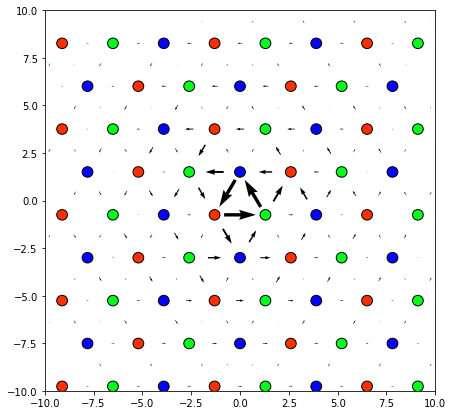

In [18]:
sd.plot_vitek(disloc_eam3, bulk, alat=eam3_alat)

In [10]:
from ase.optimize import FIRE
cylinder_r = 30
disloc_fin, dislo_fs, bulk = sd.make_barrier_configurations(calculator=lammps_fs, cylinder_r=cylinder_r)
opt = FIRE(dislo_fs)
dislo_fs.set_calculator(lammps_fs)
opt.run(fmax=1.0e-3)

      Step     Time          Energy         fmax
FIRE:    0 17:11:45       -8.899953        0.2560
FIRE:    1 17:11:45       -8.900307        0.0207
FIRE:    2 17:11:45       -8.900013        0.2341
FIRE:    3 17:11:45       -8.900134        0.1802
FIRE:    4 17:11:45       -8.900270        0.0848
FIRE:    5 17:11:45       -8.900305        0.0301
FIRE:    6 17:11:45       -8.900305        0.0283
FIRE:    7 17:11:45       -8.900306        0.0250
FIRE:    8 17:11:45       -8.900307        0.0202
FIRE:    9 17:11:45       -8.900308        0.0142
FIRE:   10 17:11:45       -8.900309        0.0075
FIRE:   11 17:11:45       -8.900309        0.0003
FIRE:   12 17:11:45       -8.900309        0.0070
FIRE:   13 17:11:45       -8.900309        0.0069
FIRE:   14 17:11:45       -8.900309        0.0067
FIRE:   15 17:11:45       -8.900309        0.0064
FIRE:   16 17:11:45       -8.900309        0.0060
FIRE:   17 17:11:45       -8.900309        0.0055
FIRE:   18 17:11:45       -8.900309        0.0050
F

FIRE:   84 17:11:48    -7876.350988        0.0028
FIRE:   85 17:11:48    -7876.350990        0.0028
FIRE:   86 17:11:48    -7876.350992        0.0029
FIRE:   87 17:11:48    -7876.350995        0.0029
FIRE:   88 17:11:48    -7876.350999        0.0029
FIRE:   89 17:11:48    -7876.351003        0.0029
FIRE:   90 17:11:48    -7876.351008        0.0029
FIRE:   91 17:11:48    -7876.351015        0.0030
FIRE:   92 17:11:48    -7876.351022        0.0030
FIRE:   93 17:11:48    -7876.351031        0.0031
FIRE:   94 17:11:48    -7876.351042        0.0032
FIRE:   95 17:11:49    -7876.351056        0.0033
FIRE:   96 17:11:49    -7876.351073        0.0034
FIRE:   97 17:11:49    -7876.351094        0.0036
FIRE:   98 17:11:49    -7876.351121        0.0040
FIRE:   99 17:11:49    -7876.351157        0.0044
FIRE:  100 17:11:49    -7876.351208        0.0054
FIRE:  101 17:11:49    -7876.351286        0.0076
FIRE:  102 17:11:49    -7876.351422        0.0110
FIRE:  103 17:11:49    -7876.351690        0.0165


True

# FS dislocation relaxed with FS

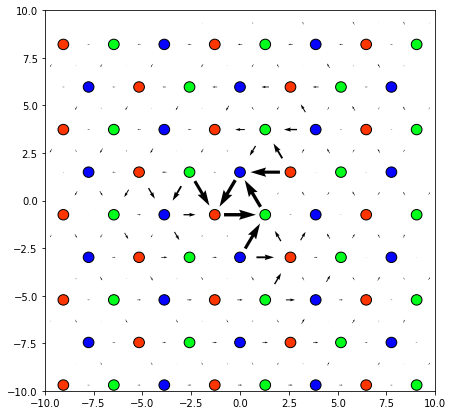

In [11]:
sd.plot_vitek(dislo_fs, bulk, alat=fs_alat)

In [12]:
disloc_fin, disloc_eam3, bulk = sd.make_barrier_configurations(calculator=lammps_eam3, cylinder_r=cylinder_r)
disloc_eam3.set_calculator(Rescaled_lammps)
opt = FIRE(disloc_eam3)
opt.run(fmax=1.0e-3)

      Step     Time          Energy         fmax
FIRE:    0 17:11:53       -8.888960        1.3604
FIRE:    1 17:11:53       -8.899137        0.1274
FIRE:    2 17:11:53       -8.892617        0.9791
FIRE:    3 17:11:53       -8.894767        0.8054
FIRE:    4 17:11:53       -8.897611        0.4864
FIRE:    5 17:11:53       -8.899191        0.0735
FIRE:    6 17:11:53       -8.898097        0.4582
FIRE:    7 17:11:53       -8.898224        0.4319
FIRE:    8 17:11:53       -8.898449        0.3806
FIRE:    9 17:11:53       -8.898720        0.3072
FIRE:   10 17:11:53       -8.898976        0.2156
FIRE:   11 17:11:53       -8.899158        0.1111
FIRE:   12 17:11:53       -8.899224        0.0032
FIRE:   13 17:11:53       -8.899169        0.0942
FIRE:   14 17:11:53       -8.899171        0.0931
FIRE:   15 17:11:53       -8.899173        0.0908
FIRE:   16 17:11:53       -8.899177        0.0874
FIRE:   17 17:11:53       -8.899182        0.0830
FIRE:   18 17:11:53       -8.899188        0.0775
F

FIRE:   69 17:11:57    -6811.495264        0.0029
FIRE:   70 17:11:57    -6811.495265        0.0029
FIRE:   71 17:11:57    -6811.495266        0.0029
FIRE:   72 17:11:57    -6811.495268        0.0029
FIRE:   73 17:11:57    -6811.495269        0.0029
FIRE:   74 17:11:57    -6811.495271        0.0029
FIRE:   75 17:11:57    -6811.495273        0.0029
FIRE:   76 17:11:57    -6811.495276        0.0028
FIRE:   77 17:11:57    -6811.495280        0.0028
FIRE:   78 17:11:57    -6811.495285        0.0027
FIRE:   79 17:11:57    -6811.495289        0.0027
FIRE:   80 17:11:58    -6811.495295        0.0026
FIRE:   81 17:11:58    -6811.495302        0.0026
FIRE:   82 17:11:58    -6811.495310        0.0025
FIRE:   83 17:11:58    -6811.495319        0.0025
FIRE:   84 17:11:58    -6811.495329        0.0025
FIRE:   85 17:11:58    -6811.495342        0.0025
FIRE:   86 17:11:58    -6811.495356        0.0026
FIRE:   87 17:11:58    -6811.495372        0.0027
FIRE:   88 17:11:58    -6811.495392        0.0029


True

# EAM3 dislocation relaxed with rescaled calcualter based on FS

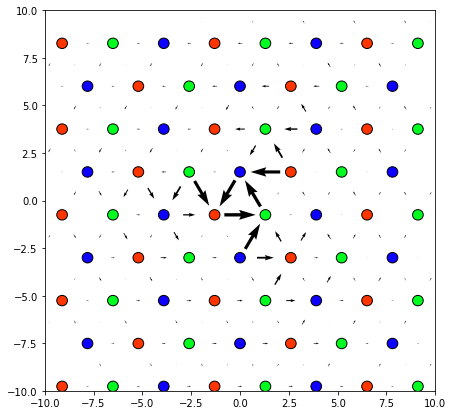

In [13]:
sd.plot_vitek(disloc_eam3, bulk)

In [75]:
N_qm_at = "3"
cylinder_r = 30
ext = 0.2
buff = 12
# Number of atoms in the qn region is [3, 6, 12, 18]
qm_radii = dict([("3", eam3_alat*np.sqrt(2.0)/3.0 + ext),
                ("6", eam3_alat*2.0*np.sqrt(2.0)/3.0 + ext),
                ("12", eam3_alat*np.sqrt(6.0)/2.0 + ext),
                ("18", eam3_alat*(np.sqrt(6.0)/2.0 + np.sqrt(2.0)/3.0) + ext)])

qm_radius = qm_radii[N_qm_at]

disloc_fin, disloc_eam3, bulk = sd.make_barrier_configurations(calculator=lammps_eam3, cylinder_r=cylinder_r)

cent_x = np.sqrt(6.0)*eam3_alat/3.0

x, y, z = disloc_eam3.positions.T
radius1 = np.sqrt(x**2 + y**2)
radius2 = np.sqrt((x-cent_x)**2 + y**2)
qm_region_mask = (radius1 < qm_radius) | (radius2 < qm_radius)
qm_buffer_mask = (radius1 < qm_radius + buff) | (radius2 < qm_radius + buff)

print(cent_x + qm_radius)
print(qm_radius)

      Step     Time          Energy         fmax
FIRE:    0 17:47:53       -8.888960        1.3604
FIRE:    1 17:47:53       -8.899137        0.1274
FIRE:    2 17:47:53       -8.892617        0.9791
FIRE:    3 17:47:53       -8.894767        0.8054
FIRE:    4 17:47:53       -8.897611        0.4864
FIRE:    5 17:47:53       -8.899191        0.0735
FIRE:    6 17:47:53       -8.898097        0.4582
FIRE:    7 17:47:53       -8.898224        0.4319
FIRE:    8 17:47:53       -8.898449        0.3806
FIRE:    9 17:47:53       -8.898720        0.3072
FIRE:   10 17:47:53       -8.898976        0.2156
FIRE:   11 17:47:53       -8.899158        0.1111
FIRE:   12 17:47:53       -8.899224        0.0032
FIRE:   13 17:47:53       -8.899169        0.0942
FIRE:   14 17:47:53       -8.899171        0.0931
FIRE:   15 17:47:53       -8.899173        0.0908
FIRE:   16 17:47:53       -8.899177        0.0874
FIRE:   17 17:47:53       -8.899182        0.0830
FIRE:   18 17:47:53       -8.899188        0.0775
F

In [157]:
atoms = disloc_eam3
qm_selection_mask = qm_region_mask
qm_buffer_mask = qm_buffer_mask

buffer_width = 10.
vacuum=5.

qm_calc = lammps_eam3
mm_calc = Rescaled_lammps

In [158]:
# get the radius of the qm_selection in non periodic directions
qm_selection_atoms = atoms[qm_selection_mask]

non_pbc_directions = np.logical_not(atoms.pbc)

#identify qm radius as an larges distance from the center of the cluster
qm_positions = qm_selection_atoms.get_positions()
qm_center = qm_positions.mean(axis=0)

non_periodic_centered_cordinates = (qm_positions - qm_center).T[non_pbc_directions]

qm_radus = np.linalg.norm(non_periodic_centered_cordinates.T, axis=1).max()

# identify atoms in region < qm_radius + buffer
centered_atoms_positions = atoms.get_positions() - qm_center
distances_from_center = np.linalg.norm(centered_atoms_positions.T[non_pbc_directions].T, axis=1)

qm_buffer_mask = distances_from_center < qm_radius + buffer_width

for index, buffer_atom in enumerate(qm_buffer_mask & np.logical_not(qm_selection_mask)):
    if buffer_atom:
        distance = np.linalg.norm((qm_positions - atoms[index].position).T[non_pbc_directions].T, axis=1)
        
        if distance.min() > buffer_width:
            qm_buffer_mask[i] = False

In [159]:
# start withe force evaluation by mm part for all the atoms
tot_force = mm_calc.get_forces(atoms)

qm_atoms = atoms.copy()
qm_buffer_atoms = qm_atoms[qm_buffer_mask]
qm_buffer_atoms.constraints = []
for index, non_pbc in enumerate(non_pbc_directions):
    if non_pbc:
        qm_buffer_atoms.cell[index][index] = qm_radius + buffer_width + vacuum
    else:
        qm_buffer_atoms.cell[index] = atoms.cell[index]
    

qm_buffer_force = qm_calc.get_forces(qm_buffer_atoms)

tot_force[qm_selection_mask] = qm_buffer_force[qm_region_mask[qm_buffer_mask]]


In [76]:
class ForceQMMM(Calculator):
    """
    Force based QMMM calculator
    """
    implemented_properties = ['forces', "energy"]
    
    def __init__(self, 
                 atoms, 
                 qm_selection_mask, 
                 qm_calc, 
                 mm_calc, 
                 buffer_width,
                 vacuum=5.):
        
        """
        ForceQMMM object.

        parameters:

        selection: list of int, slice object or list of bool
            Selection out of all the atoms that belong to the QM part.
        qmcalc: Calculator object
            QM-calculator.
        mmcalc: Calculator object 
            MM-calculator used for QM region. (should be scaled)
        vacuum: float or None
            Amount of vacuum to add around QM atoms.

        """
        
        self.qm_selection_mask = qm_selection_mask
        self.qm_calc = qm_calc
        self.mm_calc = mm_calc
        self.vacuum = vacuum
        self.buffer_width = buffer_width
        
        self.qm_buffer_mask = None
        self.cell = None
        self.qm_shift = None
        
        Calculator.__init__(self)
    
    def initialize_qm_buffer_mask(self, atoms):
        """
        Initialises system to perform qm calculation on
        """
        
        # get the radius of the qm_selection in non periodic directions
        qm_positions = atoms[self.qm_selection_mask].get_positions()
        #identify qm radius as an larges distance from the center of the cluster (overestimation)
        qm_center = qm_positions.mean(axis=0)
        
        non_pbc_directions = np.logical_not(self.atoms.pbc)
       
        centered_positions = atoms.get_positions() 
        
        for i, non_pbc in enumerate(non_pbc_directions):
            
            if non_pbc:
                
                qm_positions.T[i] -= qm_center[i]        
                centered_positions.T[i] -= qm_center[i] 
                
        qm_radius = np.linalg.norm(qm_positions.T, axis=1).max()    

        self.cell = self.atoms.cell.copy()
        
        for i, non_pbc in enumerate(non_pbc_directions):
            
            if non_pbc:
                self.cell[i][i] = 2.0 * (qm_radius + self.buffer_width + self.vacuum)
        
        # identify atoms in region < qm_radius + buffer
        
        distances_from_center = np.linalg.norm(centered_positions.T[non_pbc_directions].T, axis=1)
       
        self.qm_buffer_mask = distances_from_center < qm_radius + self.buffer_width
        
        # esclude atoms that are too far (in case of non spherical region)
        for i, buffer_atom in enumerate(qm_buffer_mask & np.logical_not(self.qm_selection_mask)):
            
            if buffer_atom:
                distance = np.linalg.norm((qm_positions - centered_positions[i]).T[non_pbc_directions].T, axis=1)
                if distance.min() > self.buffer_width:
                    self.qm_buffer_mask[i] = False
                    print("deleting atom number %i" % i, distance.min(), self.buffer_width)
        
        
      
       
    def calculate(self, atoms, properties, system_changes):
        Calculator.calculate(self, atoms, properties, system_changes)
        
        if self.qm_buffer_mask is None:
            self.initialize_qm_buffer_mask(atoms)
        
        # initialize the object
        qm_buffer_atoms = atoms.copy()
        qm_buffer_atoms = qm_buffer_atoms[self.qm_buffer_mask]
        del qm_buffer_atoms.constraints
        
        qm_buffer_atoms.set_cell(self.cell)        
        qm_shift = .5*qm_buffer_atoms.cell.diagonal() - qm_buffer_atoms.positions.mean(axis=0)
        
        qm_buffer_atoms.set_cell(self.cell)
        qm_buffer_atoms.positions += qm_shift
        
        forces = self.mm_calc.get_forces(atoms)
        
        qm_forces = self.qm_calc.get_forces(qm_buffer_atoms)
        
        #qm_buffer_atoms.write("ForceQMMM/qm_buffer.xyz")
        #qm_buffer_atoms[self.qm_selection_mask[self.qm_buffer_mask]].write("ForceQMMM/qm.xyz")
        
        forces[self.qm_selection_mask] = qm_forces[self.qm_selection_mask[self.qm_buffer_mask]]
        
        '''
        Taken from original ForceMixCarver needs reimplementation
        
        # Reindexing check - will occur when we have multiple species
        
        if np.linalg.norm(scaled_qm_positions-qm_system.get_positions()) > 1e-9:
            #print "ATOMS REINDEXING IN QM CALC!"
            remap = np.zeros(dft_atom_count).astype(int)
            for i in range(len(remap)):
                remap[i] = find_mic(np.linalg.norm(qm_system.get_positions()-scaled_qm_positions[i],self.cell,pbc=self.pbc))
            qm_force[self.dft_atoms] = tmp_qmf[remap]
        '''
        
        self.results['forces'] = forces
        self.results['energy'] = 0.0

In [86]:
N_qm_at = "3"
cylinder_r = 30
ext = 0.2
buff = 12
# Number of atoms in the qn region is [3, 6, 12, 18]
qm_radii = dict([("3", eam3_alat*np.sqrt(2.0)/3.0 + ext),
                ("6", eam3_alat*2.0*np.sqrt(2.0)/3.0 + ext),
                ("12", eam3_alat*np.sqrt(6.0)/2.0 + ext),
                ("18", eam3_alat*(np.sqrt(6.0)/2.0 + np.sqrt(2.0)/3.0) + ext)])

qm_radius = qm_radii[N_qm_at]
#qm_radius = 0.0

disloc_fin, disloc_ini, bulk = sd.make_barrier_configurations(calculator=lammps_eam3,
                                                              cylinder_r=cylinder_r)

cent_x = np.sqrt(6.0)*eam3_alat/3.0

x, y, z = disloc_ini.positions.T
radius1 = np.sqrt(x**2 + y**2)
radius2 = np.sqrt((x-cent_x)**2 + y**2)
qm_region_mask = (radius1 < qm_radius) | (radius2 < qm_radius)

region = disloc_ini.get_array("region")
region[qm_region_mask] = np.full_like(region[qm_region_mask], "QM")

qm_buffer_mask = (radius1 < qm_radius + buff) | (radius2 < qm_radius + buff)
qm_buffer_mask[qm_region_mask] = np.zeros_like(qm_buffer_mask[qm_region_mask])
buff_only_mask = qm_buffer_mask

region[buff_only_mask] = np.full_like(region[buff_only_mask], "buffer")
disloc_ini.set_array("region", region)
disloc_fin.set_array("region", region)

#radius = np.sqrt(x**2 + y**2)
#qm_region_mask = radius < qm_radius

print("Total number of atoms in configuration: %i" % disloc_ini.get_number_of_atoms())

print ("\nNumber of atoms in qm region of %.1f" % qm_radius +
                                    "A : %i" % np.count_nonzero(qm_region_mask))

print ("together with the buffer of %.1f" % (qm_radius + buff) +
                                    "A %i" % np.count_nonzero(qm_buffer_mask))


# copied this from Tom's scripts: need to check and understand
#alpha = dft_alat/eam_alat
#eam_bulk_mod = (eam_C11 + 2.0*eam_C12)/3.0
#dft_bulk_mod = (dft_C11 + 2.0*dft_C12)/3.0
#beta = eam_bulk_mod/dft_bulk_mod/alpha/alpha/alpha

print ("Alpha: %.2f, beta: %.2f" % (alpha, beta))

qmmm_pot = ForceQMMM(disloc_ini, 
                     qm_region_mask,
                     lammps_eam3, 
                     Rescaled_lammps,
                     buffer_width=buff)



      Step     Time          Energy         fmax
FIRE:    0 10:49:25       -8.888960        1.3604
FIRE:    1 10:49:25       -8.899137        0.1274
FIRE:    2 10:49:25       -8.892617        0.9791
FIRE:    3 10:49:25       -8.894767        0.8054
FIRE:    4 10:49:26       -8.897611        0.4864
FIRE:    5 10:49:26       -8.899191        0.0735
FIRE:    6 10:49:26       -8.898097        0.4582
FIRE:    7 10:49:26       -8.898224        0.4319
FIRE:    8 10:49:26       -8.898449        0.3806
FIRE:    9 10:49:26       -8.898720        0.3072
FIRE:   10 10:49:26       -8.898976        0.2156
FIRE:   11 10:49:26       -8.899158        0.1111
FIRE:   12 10:49:26       -8.899224        0.0032
FIRE:   13 10:49:26       -8.899169        0.0942
FIRE:   14 10:49:26       -8.899171        0.0931
FIRE:   15 10:49:26       -8.899173        0.0908
FIRE:   16 10:49:26       -8.899177        0.0874
FIRE:   17 10:49:26       -8.899182        0.0830
FIRE:   18 10:49:26       -8.899188        0.0775
F

In [78]:
disloc_ini.set_calculator(qmmm_pot)
qmmm_forces = disloc_ini.get_forces()
disloc_ini.get_forces()[qm_region_mask]

array([[ 4.43881033e-02,  2.56274833e-02, -1.46634371e-11],
       [-4.43881033e-02,  2.56274834e-02, -1.31339384e-13],
       [ 5.86749150e-01,  9.32304101e-01, -3.68128438e-01],
       [ 4.56420474e+00,  2.63514483e+00, -2.68796096e-12],
       [ 2.64783750e-11, -5.12549668e-02,  1.55603308e-11]])

In [27]:
qmmm_forces = disloc_ini.get_forces()

In [87]:
disloc_ini.set_calculator(Rescaled_lammps)
opt = FIRE(disloc_ini)
opt.run(fmax=1.0e-3)

      Step     Time          Energy         fmax
FIRE:    0 10:49:34    -6811.394287        0.7335
FIRE:    1 10:49:34    -6811.414013        0.5661
FIRE:    2 10:49:34    -6811.438625        0.2832
FIRE:    3 10:49:34    -6811.453237        0.1885
FIRE:    4 10:49:34    -6811.457341        0.2463
FIRE:    5 10:49:34    -6811.458703        0.2272
FIRE:    6 10:49:34    -6811.461127        0.1905
FIRE:    7 10:49:34    -6811.464098        0.1390
FIRE:    8 10:49:34    -6811.467033        0.0870
FIRE:    9 10:49:34    -6811.469457        0.0579
FIRE:   10 10:49:34    -6811.471172        0.0535
FIRE:   11 10:49:34    -6811.472336        0.1054
FIRE:   12 10:49:34    -6811.473437        0.1423
FIRE:   13 10:49:34    -6811.474902        0.1569
FIRE:   14 10:49:34    -6811.477023        0.1438
FIRE:   15 10:49:34    -6811.479668        0.1006
FIRE:   16 10:49:34    -6811.482191        0.0335
FIRE:   17 10:49:34    -6811.483873        0.0448
FIRE:   18 10:49:34    -6811.484841        0.0972
F

FIRE:  163 10:49:40    -6811.621918        0.0082
FIRE:  164 10:49:40    -6811.621928        0.0057
FIRE:  165 10:49:40    -6811.621937        0.0055
FIRE:  166 10:49:40    -6811.621942        0.0059
FIRE:  167 10:49:40    -6811.621949        0.0069
FIRE:  168 10:49:40    -6811.621960        0.0050
FIRE:  169 10:49:40    -6811.621970        0.0049
FIRE:  170 10:49:41    -6811.621977        0.0048
FIRE:  171 10:49:41    -6811.621987        0.0048
FIRE:  172 10:49:41    -6811.621999        0.0047
FIRE:  173 10:49:41    -6811.622011        0.0046
FIRE:  174 10:49:41    -6811.622024        0.0044
FIRE:  175 10:49:41    -6811.622037        0.0042
FIRE:  176 10:49:41    -6811.622052        0.0037
FIRE:  177 10:49:41    -6811.622067        0.0050
FIRE:  178 10:49:41    -6811.622085        0.0031
FIRE:  179 10:49:41    -6811.622102        0.0039
FIRE:  180 10:49:41    -6811.622114        0.0067
FIRE:  181 10:49:41    -6811.622122        0.0019
FIRE:  182 10:49:41    -6811.622121        0.0046


True

In [71]:
disloc_ini.set_calculator(lammps_eam3)
disloc_ini.get_forces()[qm_region_mask]

array([[ 0.10448765,  0.27581462,  0.22443196],
       [-0.29028464, -0.04003101,  0.20976139],
       [ 0.39016158,  0.08988052, -0.10855811],
       [-0.45145633,  0.20517265, -0.03286792],
       [ 0.19202833, -0.23945197,  0.20879354]])

In [ ]:
qmmm_forces = disloc_ini.get_forces()

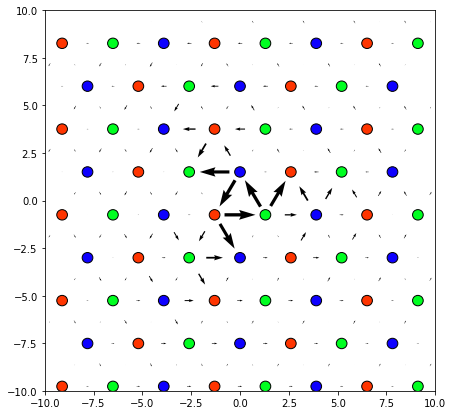

In [72]:
sd.plot_vitek(disloc_ini, bulk)

In [79]:
disloc_ini.set_calculator(qmmm_pot)
opt = FIRE(disloc_ini)
opt.run(fmax=1.0e-3)

      Step     Time          Energy         fmax
FIRE:    0 17:48:32        0.000000        5.2703
FIRE:    1 17:48:33        0.000000        2.6290
FIRE:    2 17:48:33        0.000000        1.4116
FIRE:    3 17:48:33        0.000000        2.4529
FIRE:    4 17:48:33        0.000000        2.1473
FIRE:    5 17:48:33        0.000000        1.5462
FIRE:    6 17:48:33        0.000000        0.6975
FIRE:    7 17:48:33        0.000000        0.4348
FIRE:    8 17:48:33        0.000000        0.9298
FIRE:    9 17:48:33        0.000000        0.8794
FIRE:   10 17:48:33        0.000000        0.7807
FIRE:   11 17:48:33        0.000000        0.6381
FIRE:   12 17:48:33        0.000000        0.4584
FIRE:   13 17:48:33        0.000000        0.3040
FIRE:   14 17:48:33        0.000000        0.2961
FIRE:   15 17:48:33        0.000000        0.2873
FIRE:   16 17:48:33        0.000000        0.3872
FIRE:   17 17:48:33        0.000000        0.5524
FIRE:   18 17:48:33        0.000000        0.6542
F

FIRE:  163 17:48:41        0.000000        0.0189
FIRE:  164 17:48:41        0.000000        0.0159
FIRE:  165 17:48:41        0.000000        0.0126
FIRE:  166 17:48:41        0.000000        0.0096
FIRE:  167 17:48:41        0.000000        0.0080
FIRE:  168 17:48:41        0.000000        0.0085
FIRE:  169 17:48:41        0.000000        0.0103
FIRE:  170 17:48:42        0.000000        0.0119
FIRE:  171 17:48:42        0.000000        0.0124
FIRE:  172 17:48:42        0.000000        0.0112
FIRE:  173 17:48:42        0.000000        0.0089
FIRE:  174 17:48:42        0.000000        0.0081
FIRE:  175 17:48:42        0.000000        0.0103
FIRE:  176 17:48:42        0.000000        0.0120
FIRE:  177 17:48:42        0.000000        0.0104
FIRE:  178 17:48:42        0.000000        0.0079
FIRE:  179 17:48:42        0.000000        0.0097
FIRE:  180 17:48:42        0.000000        0.0092
FIRE:  181 17:48:42        0.000000        0.0085
FIRE:  182 17:48:42        0.000000        0.0109


FIRE:  327 17:48:50        0.000000        0.0093
FIRE:  328 17:48:50        0.000000        0.0095
FIRE:  329 17:48:50        0.000000        0.0081
FIRE:  330 17:48:50        0.000000        0.0055
FIRE:  331 17:48:50        0.000000        0.0042
FIRE:  332 17:48:50        0.000000        0.0064
FIRE:  333 17:48:50        0.000000        0.0075
FIRE:  334 17:48:50        0.000000        0.0056
FIRE:  335 17:48:50        0.000000        0.0044
FIRE:  336 17:48:50        0.000000        0.0072
FIRE:  337 17:48:50        0.000000        0.0059
FIRE:  338 17:48:51        0.000000        0.0048
FIRE:  339 17:48:51        0.000000        0.0063
FIRE:  340 17:48:51        0.000000        0.0048
FIRE:  341 17:48:51        0.000000        0.0062
FIRE:  342 17:48:51        0.000000        0.0068
FIRE:  343 17:48:51        0.000000        0.0053
FIRE:  344 17:48:51        0.000000        0.0040
FIRE:  345 17:48:51        0.000000        0.0040
FIRE:  346 17:48:51        0.000000        0.0050


FIRE:  491 17:48:59        0.000000        0.0042
FIRE:  492 17:48:59        0.000000        0.0110
FIRE:  493 17:48:59        0.000000        0.0483
FIRE:  494 17:48:59        0.000000        0.1976
FIRE:  495 17:48:59        0.000000        0.0773
FIRE:  496 17:48:59        0.000000        0.0510
FIRE:  497 17:48:59        0.000000        0.0077
FIRE:  498 17:48:59        0.000000        0.0382
FIRE:  499 17:48:59        0.000000        0.0350
FIRE:  500 17:48:59        0.000000        0.0287
FIRE:  501 17:48:59        0.000000        0.0200
FIRE:  502 17:48:59        0.000000        0.0099
FIRE:  503 17:49:00        0.000000        0.0038
FIRE:  504 17:49:00        0.000000        0.0116
FIRE:  505 17:49:00        0.000000        0.0114
FIRE:  506 17:49:00        0.000000        0.0110
FIRE:  507 17:49:00        0.000000        0.0103
FIRE:  508 17:49:00        0.000000        0.0094
FIRE:  509 17:49:00        0.000000        0.0084
FIRE:  510 17:49:00        0.000000        0.0073


FIRE:  655 17:49:08        0.000000        0.0061
FIRE:  656 17:49:08        0.000000        0.0047
FIRE:  657 17:49:08        0.000000        0.0039
FIRE:  658 17:49:08        0.000000        0.0052
FIRE:  659 17:49:08        0.000000        0.0061
FIRE:  660 17:49:08        0.000000        0.0052
FIRE:  661 17:49:08        0.000000        0.0039
FIRE:  662 17:49:08        0.000000        0.0053
FIRE:  663 17:49:08        0.000000        0.0048
FIRE:  664 17:49:08        0.000000        0.0043
FIRE:  665 17:49:08        0.000000        0.0055
FIRE:  666 17:49:08        0.000000        0.0041
FIRE:  667 17:49:08        0.000000        0.0050
FIRE:  668 17:49:08        0.000000        0.0056
FIRE:  669 17:49:08        0.000000        0.0043
FIRE:  670 17:49:08        0.000000        0.0040
FIRE:  671 17:49:08        0.000000        0.0046
FIRE:  672 17:49:09        0.000000        0.0083
FIRE:  673 17:49:09        0.000000        0.0319
FIRE:  674 17:49:09        0.000000        0.1198


FIRE:  819 17:49:16        0.000000        0.0107
FIRE:  820 17:49:16        0.000000        0.0118
FIRE:  821 17:49:16        0.000000        0.0113
FIRE:  822 17:49:17        0.000000        0.0119
FIRE:  823 17:49:17        0.000000        0.0131
FIRE:  824 17:49:17        0.000000        0.0127
FIRE:  825 17:49:17        0.000000        0.0110
FIRE:  826 17:49:17        0.000000        0.0138
FIRE:  827 17:49:17        0.000000        0.0282
FIRE:  828 17:49:17        0.000000        0.0989
FIRE:  829 17:49:17        0.000000        0.0137
FIRE:  830 17:49:17        0.000000        0.0122
FIRE:  831 17:49:17        0.000000        0.0106
FIRE:  832 17:49:17        0.000000        0.0111
FIRE:  833 17:49:17        0.000000        0.0126
FIRE:  834 17:49:17        0.000000        0.0131
FIRE:  835 17:49:17        0.000000        0.0120
FIRE:  836 17:49:17        0.000000        0.0107
FIRE:  837 17:49:17        0.000000        0.0109
FIRE:  838 17:49:17        0.000000        0.0115


FIRE:  983 17:49:25        0.000000        0.0098
FIRE:  984 17:49:25        0.000000        0.0081
FIRE:  985 17:49:25        0.000000        0.0073
FIRE:  986 17:49:25        0.000000        0.0078
FIRE:  987 17:49:26        0.000000        0.0089
FIRE:  988 17:49:26        0.000000        0.0100
FIRE:  989 17:49:26        0.000000        0.0102
FIRE:  990 17:49:26        0.000000        0.0093
FIRE:  991 17:49:26        0.000000        0.0079
FIRE:  992 17:49:26        0.000000        0.0073
FIRE:  993 17:49:26        0.000000        0.0086
FIRE:  994 17:49:26        0.000000        0.0095
FIRE:  995 17:49:26        0.000000        0.0083
FIRE:  996 17:49:26        0.000000        0.0072
FIRE:  997 17:49:26        0.000000        0.0085
FIRE:  998 17:49:26        0.000000        0.0079
FIRE:  999 17:49:26        0.000000        0.0074
FIRE:  1000 17:49:26        0.000000        0.0085
FIRE:  1001 17:49:26        0.000000        0.0070
FIRE:  1002 17:49:26        0.000000        0.00

FIRE:  1144 17:49:34        0.000000        0.0088
FIRE:  1145 17:49:34        0.000000        0.0027
FIRE:  1146 17:49:34        0.000000        0.0038
FIRE:  1147 17:49:34        0.000000        0.0081
FIRE:  1148 17:49:34        0.000000        0.0089
FIRE:  1149 17:49:34        0.000000        0.0063
FIRE:  1150 17:49:34        0.000000        0.0017
FIRE:  1151 17:49:35        0.000000        0.0044
FIRE:  1152 17:49:35        0.000000        0.0072
FIRE:  1153 17:49:35        0.000000        0.0046
FIRE:  1154 17:49:35        0.000000        0.0023
FIRE:  1155 17:49:35        0.000000        0.0063
FIRE:  1156 17:49:35        0.000000        0.0017
FIRE:  1157 17:49:35        0.000000        0.0061
FIRE:  1158 17:49:35        0.000000        0.0017
FIRE:  1159 17:49:35        0.000000        0.0071
FIRE:  1160 17:49:35        0.000000        0.0047
FIRE:  1161 17:49:35        0.000000        0.0016
FIRE:  1162 17:49:35        0.000000        0.0024
FIRE:  1163 17:49:35        0.0

True

# Note the difference in the amount of steps!

1200 vs 200


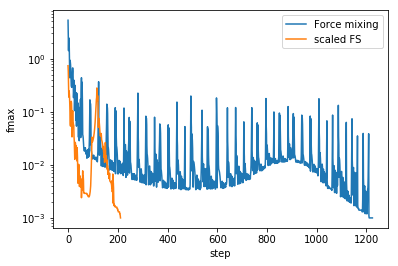

In [95]:
fire_mixed_output = np.loadtxt("mixed_fire.txt", usecols=(1, 4))
scaled_fire_output = np.loadtxt("rescaled_FIRE.txt", usecols=(1, 4))

fig, ax = plt.subplots()
ax.semilogy(fire_mixed_output.T[0], fire_mixed_output.T[1], label="Force mixing")
ax.semilogy(scaled_fire_output.T[0], scaled_fire_output.T[1], label="scaled FS")
ax.set_xlabel("step")
ax.set_ylabel("fmax")
ax.legend(loc="best")

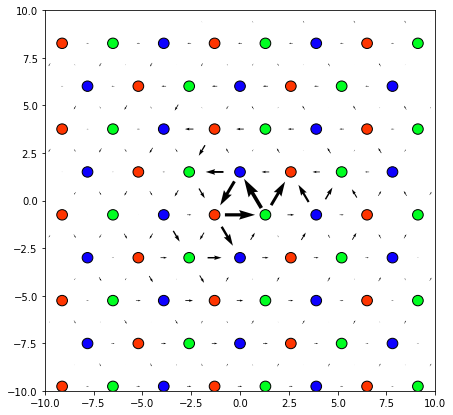

In [80]:
sd.plot_vitek(disloc_ini, bulk)

In [173]:
qm_buffer_atoms.set_calculator(lammps_eam3)
qm_buffer_atoms.get_forces()

array([[ 3.37763010e+01,  1.42757100e+01,  3.93506958e+00],
       [ 3.72996629e+01,  1.04033870e+02, -3.93641796e+01],
       [ 2.34428978e+01,  2.00685286e+01,  3.70157929e+00],
       [ 1.69757645e+02, -1.86840046e+01, -1.03519477e+02],
       [-6.02118990e+01,  4.16097164e+01, -3.43677671e+01],
       [ 1.28110401e+02, -1.52323332e+01, -5.71173505e+01],
       [-1.02028754e+00, -1.52192467e+00, -4.41849696e-02],
       [ 3.31339978e+01,  2.11971447e+00, -1.03784401e+01],
       [-2.67825890e+00,  3.75056123e+00,  2.08724262e+01],
       [-3.97373941e+00,  2.96199734e+00,  2.06877338e+01],
       [ 1.05760885e+02,  9.93923020e-01, -1.38880386e+01],
       [ 1.10076353e+02,  3.14556923e+00,  2.19804814e+01],
       [-6.28007999e+00,  2.57863478e+00,  6.17434412e-02],
       [-1.38474869e+01,  3.66546284e+00,  4.33824247e+01],
       [ 1.11592832e+01,  4.31555255e+00,  8.06592191e+01],
       [ 9.64767529e+00,  2.45388480e+00,  7.90314231e+01],
       [ 1.63282756e+02,  8.00283655e-01

In [182]:
from ase.io import write

In [183]:
mkdir ForceQMMM


In [211]:
.5*qm_buffer_atoms.cell.diagonal() - qm_buffer_atoms.positions.mean(axis=0)

array([-8.35127219e+00, -8.35127219e+00, -1.33226763e-15])

array([16.70254438, 16.70254438,  1.38017514])

In [216]:
qm_buffer_atoms.positions.min()

-0.8949436827161769